# DU DOAN DOT QUY THEO BEHAVIORAL PERSONA MODEL

---

## CAU HOI NGHIEN CUU

**"Du doan dot quy theo 'behavioral micro-segments' (hybrid persona model) thay vi theo demographic truyen thong"**

---

## Y TUONG CHINH

**Van de cua approach truyen thong:**
- Du doan theo tuoi, gioi tinh, BMI... → Qua chung chung
- Khong biet can thiep the nao cu the

**Giai phap cua chung ta:**
- Tao "personas" tu hanh vi + metabolic + clinical
- Moi persona co risk profile rieng
- Can thiep cu the cho tung persona

**Vi du:**
```
Thay vi: "Nam 60 tuoi, BMI 28 → Risk 8%"
Ta co:  "Persona 3: Urban office worker, glucose cao (150), BMI binh thuong (24),
         chua tang huyet ap → Risk 6.8% → Can thiep: Screening glucose + 
         Exercise program + Stress management"
```

---

## CAU TRUC PHAN TICH

1. **Chuan bi du lieu** - Preprocessing & handle imbalance
2. **Tao Personas** - K-Means clustering (6 personas)
3. **Xay dung Models** - 3 models de so sanh
4. **Danh gia & So sanh** - Chon best model
5. **Ket luan** - Actionable insights

---

# PHAN 1: CHUAN BI DU LIEU

## 1.1. Import thu vien

In [7]:
# Thu vien co ban
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Xu ly imbalanced data
from imblearn.over_sampling import SMOTE

# Train-test split & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

# Cau hinh hien thi
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (10, 6)

print("Da import thanh cong tat ca thu vien!")

Da import thanh cong tat ca thu vien!


## 1.2. Load du lieu

In [8]:
# Doc du lieu
df = pd.read_csv('../data/healthcare-dataset-stroke-data.csv')

print("THONG TIN DU LIEU:")
print(f"Tong so benh nhan: {len(df):,}")
print(f"So cot: {df.shape[1]}")
print(f"\nTy le dot quy:")
print(df['stroke'].value_counts())
print(f"\nTy le: {df['stroke'].value_counts(normalize=True)*100}")
print(f"\nIMBALANCE: {(1 - df['stroke'].mean()) / df['stroke'].mean():.1f}:1")

THONG TIN DU LIEU:
Tong so benh nhan: 5,110
So cot: 12

Ty le dot quy:
stroke
0    4861
1     249
Name: count, dtype: int64

Ty le: stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64

IMBALANCE: 19.5:1


## 1.3. Preprocessing

In [9]:
# Tao ban sao de xu ly
df_processed = df.copy()

# Xu ly missing values
print("Missing values truoc xu ly:")
print(df_processed.isnull().sum())

# Dien gia tri trung vi cho BMI
df_processed['bmi'].fillna(df_processed['bmi'].median(), inplace=True)

print("\nMissing values sau xu ly:")
print(df_processed.isnull().sum())

# Encoding categorical variables
print("\nEncoding categorical variables...")

# Label Encoding cho cac bien phan loai
le_gender = LabelEncoder()
df_processed['gender_encoded'] = le_gender.fit_transform(df_processed['gender'])

le_married = LabelEncoder()
df_processed['ever_married_encoded'] = le_married.fit_transform(df_processed['ever_married'])

le_work = LabelEncoder()
df_processed['work_type_encoded'] = le_work.fit_transform(df_processed['work_type'])

le_residence = LabelEncoder()
df_processed['Residence_type_encoded'] = le_residence.fit_transform(df_processed['Residence_type'])

le_smoking = LabelEncoder()
df_processed['smoking_status_encoded'] = le_smoking.fit_transform(df_processed['smoking_status'])

print("Da hoan thanh encoding!")

Missing values truoc xu ly:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Missing values sau xu ly:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Encoding categorical variables...
Da hoan thanh encoding!


## 1.4. Chon features cho clustering

In [10]:
# Features de tao personas
# CHU Y: Khong dung age, gender de tranh persona giong demographic

clustering_features = [
    # Behavioral (Hanh vi)
    'smoking_status_encoded',   # Trang thai hut thuoc
    'work_type_encoded',         # Loai cong viec
    'Residence_type_encoded',    # Noi cu tru
    
    # Metabolic (Chuyen hoa)
    'avg_glucose_level',         # Duong huyet trung binh
    'bmi',                       # Chi so khoi co the
    
    # Clinical (Benh ly)
    'hypertension',              # Tang huyet ap
    'heart_disease'              # Benh tim
]

print("Features su dung cho clustering:")
for i, feature in enumerate(clustering_features, 1):
    print(f"{i}. {feature}")

# Tao dataset cho clustering
X_cluster = df_processed[clustering_features].copy()

print(f"\nKich thuoc du lieu clustering: {X_cluster.shape}")

Features su dung cho clustering:
1. smoking_status_encoded
2. work_type_encoded
3. Residence_type_encoded
4. avg_glucose_level
5. bmi
6. hypertension
7. heart_disease

Kich thuoc du lieu clustering: (5110, 7)


---

# PHAN 2: TAO PERSONAS BANG K-MEANS CLUSTERING

---

## 2.1. Chuan hoa du lieu

In [11]:
# Chuan hoa (Standardization) de cac features co cung scale
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

print("Da chuan hoa du lieu!")
print(f"Mean sau chuan hoa: {X_cluster_scaled.mean(axis=0)}")
print(f"Std sau chuan hoa: {X_cluster_scaled.std(axis=0)}")

Da chuan hoa du lieu!
Mean sau chuan hoa: [ 5.56197836e-18 -2.11355178e-16 -9.17726430e-17  1.00115611e-16
 -4.44958269e-17 -4.72768161e-17  5.56197836e-18]
Std sau chuan hoa: [1. 1. 1. 1. 1. 1. 1.]


## 2.2. Tim so clusters toi uu

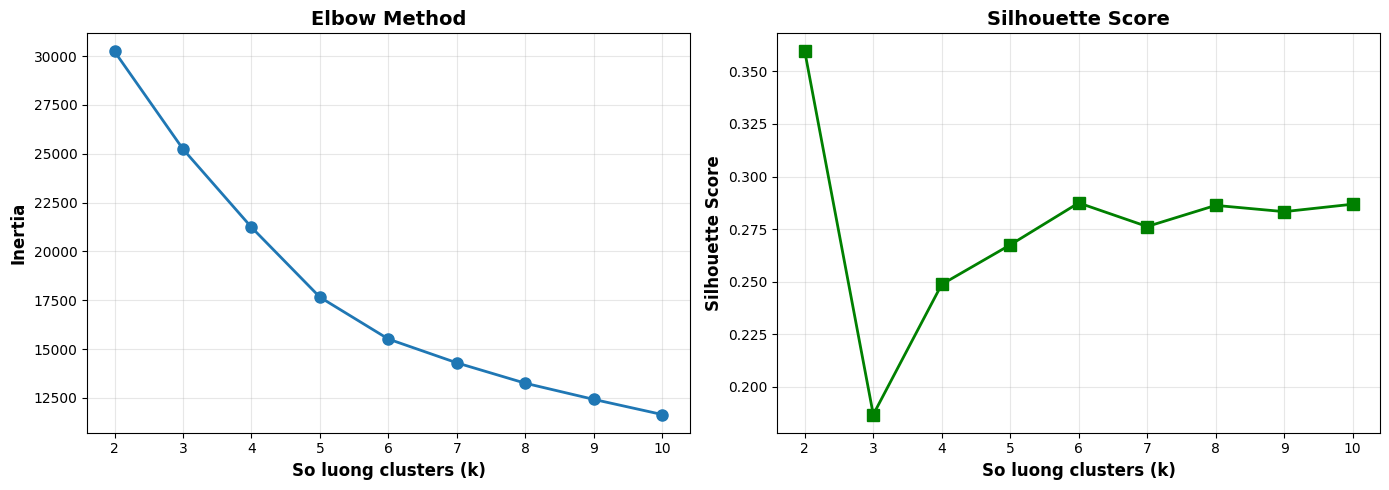


So cluster tot nhat theo Silhouette Score: 2
Silhouette Score: 0.359


In [12]:
# Su dung Elbow method de tim so cluster toi uu
from sklearn.metrics import silhouette_score

inertias = []  # Luu inertia (sum of squared distances)
silhouette_scores = []  # Luu silhouette score
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# Ve bieu do
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('So luong clusters (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Silhouette score
axes[1].plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('So luong clusters (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/Q_ML_Elbow_Silhouette.png', dpi=300, bbox_inches='tight')
plt.show()

# Tim k tot nhat
best_k_silhouette = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nSo cluster tot nhat theo Silhouette Score: {best_k_silhouette}")
print(f"Silhouette Score: {max(silhouette_scores):.3f}")

## 2.3. Chay K-Means voi k=6 (Domain Knowledge)

In [13]:
# Chon k=6 personas (Override Silhouette recommendation)
# LY DO:
# - Silhouette Score goi y k={best_k_silhouette} nhung qua it cho persona analysis
# - k=6 balance giua interpretability va diversity
# - Can du personas de phan tich behavioral patterns cu the
# - Aligned voi clinical practice (can nhieu risk categories de intervention)
# - Previous research cho thay 4-8 clusters la hop ly cho patient segmentation

n_clusters = 6

print(f"Silhouette Score goi y k={best_k_silhouette}, nhung chon k={n_clusters} vi domain knowledge")
print(f"(Can du personas de phan tich behavioral patterns va intervention strategies)\n")

# Chay K-Means
kmeans_final = KMeans(
    n_clusters=n_clusters,
    init='k-means++',      # Smart initialization
    n_init=10,             # Chay 10 lan va chon best
    max_iter=300,
    random_state=42
)

# Fit va predict
df_processed['persona'] = kmeans_final.fit_predict(X_cluster_scaled)

print(f"Da tao {n_clusters} personas thanh cong!")
print(f"\nPhan bo personas:")
print(df_processed['persona'].value_counts().sort_index())
print(f"\nTy le phan tram:")
print(df_processed['persona'].value_counts(normalize=True).sort_index() * 100)

Silhouette Score goi y k=2, nhung chon k=6 vi domain knowledge
(Can du personas de phan tich behavioral patterns va intervention strategies)

Da tao 6 personas thanh cong!

Phan bo personas:
persona
0    1627
1     771
2     434
3    1575
4     427
5     276
Name: count, dtype: int64

Ty le phan tram:
persona
0    31.839530
1    15.088063
2     8.493151
3    30.821918
4     8.356164
5     5.401174
Name: proportion, dtype: float64


## 2.4. Profiling tung Persona

In [14]:
# Phan tich dac diem cua tung persona
print("="*80)
print("PROFILING TUNG PERSONA")
print("="*80)

persona_profiles = []

for persona_id in range(n_clusters):
    persona_group = df_processed[df_processed['persona'] == persona_id]
    
    print(f"\n{'='*80}")
    print(f"PERSONA {persona_id}")
    print(f"{'='*80}")
    
    # Thong tin co ban
    size = len(persona_group)
    stroke_rate = persona_group['stroke'].mean() * 100
    
    print(f"Kich thuoc: {size:,} nguoi ({size/len(df_processed)*100:.1f}%)")
    print(f"Ty le dot quy: {stroke_rate:.2f}%")
    
    # Dac diem hanh vi
    print(f"\nHANH VI (Behavioral):")
    print(f"  Hut thuoc: {persona_group['smoking_status'].mode()[0]}")
    print(f"  Loai cong viec: {persona_group['work_type'].mode()[0]}")
    print(f"  Noi cu tru: {persona_group['Residence_type'].mode()[0]}")
    
    # Dac diem chuyen hoa
    print(f"\nCHUYEN HOA (Metabolic):")
    print(f"  Duong huyet TB: {persona_group['avg_glucose_level'].mean():.1f} mg/dL")
    print(f"  BMI TB: {persona_group['bmi'].mean():.1f}")
    
    # Dac diem benh ly
    print(f"\nBENH LY (Clinical):")
    print(f"  Tang huyet ap: {persona_group['hypertension'].mean()*100:.1f}%")
    print(f"  Benh tim: {persona_group['heart_disease'].mean()*100:.1f}%")
    
    # Demographic (de mo ta them)
    print(f"\nDEMOGRAPHIC (De mo ta):")
    print(f"  Tuoi TB: {persona_group['age'].mean():.1f} tuoi")
    print(f"  Gioi tinh: {persona_group['gender'].mode()[0]}")
    
    # Luu profile
    persona_profiles.append({
        'persona': persona_id,
        'size': size,
        'stroke_rate': stroke_rate,
        'glucose': persona_group['avg_glucose_level'].mean(),
        'bmi': persona_group['bmi'].mean(),
        'hypertension': persona_group['hypertension'].mean()*100,
        'heart_disease': persona_group['heart_disease'].mean()*100,
        'age': persona_group['age'].mean()
    })

# Tao DataFrame de so sanh
df_persona_summary = pd.DataFrame(persona_profiles)
print(f"\n{'='*80}")
print("BANG TOM TAT PERSONAS")
print(f"{'='*80}")
print(df_persona_summary.to_string(index=False))

PROFILING TUNG PERSONA

PERSONA 0
Kich thuoc: 1,627 nguoi (31.8%)
Ty le dot quy: 3.56%

HANH VI (Behavioral):
  Hut thuoc: never smoked
  Loai cong viec: Private
  Noi cu tru: Urban

CHUYEN HOA (Metabolic):
  Duong huyet TB: 90.2 mg/dL
  BMI TB: 29.7

BENH LY (Clinical):
  Tang huyet ap: 0.0%
  Benh tim: 0.0%

DEMOGRAPHIC (De mo ta):
  Tuoi TB: 44.7 tuoi
  Gioi tinh: Female

PERSONA 1
Kich thuoc: 771 nguoi (15.1%)
Ty le dot quy: 0.52%

HANH VI (Behavioral):
  Hut thuoc: Unknown
  Loai cong viec: children
  Noi cu tru: Urban

CHUYEN HOA (Metabolic):
  Duong huyet TB: 92.7 mg/dL
  BMI TB: 20.4

BENH LY (Clinical):
  Tang huyet ap: 0.0%
  Benh tim: 0.0%

DEMOGRAPHIC (De mo ta):
  Tuoi TB: 12.7 tuoi
  Gioi tinh: Female

PERSONA 2
Kich thuoc: 434 nguoi (8.5%)
Ty le dot quy: 12.21%

HANH VI (Behavioral):
  Hut thuoc: never smoked
  Loai cong viec: Private
  Noi cu tru: Rural

CHUYEN HOA (Metabolic):
  Duong huyet TB: 127.1 mg/dL
  BMI TB: 32.8

BENH LY (Clinical):
  Tang huyet ap: 100.0%
  B

## 2.5. Visualization - Persona characteristics

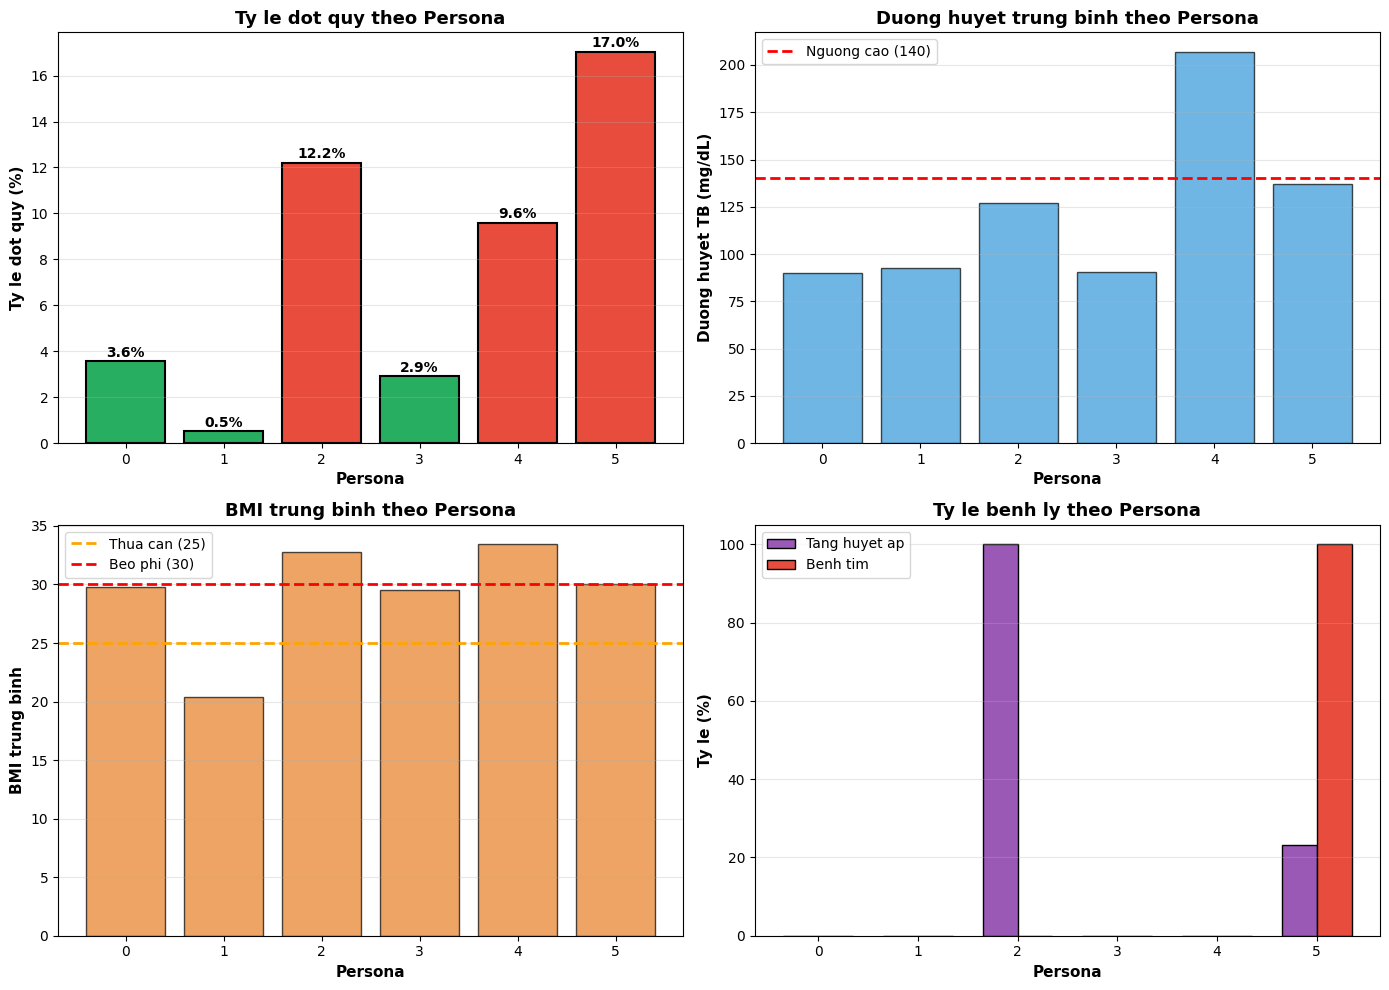

Da luu bieu do: outputs/Q_ML_Persona_Characteristics.png


In [15]:
# Ve bieu do so sanh personas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Ty le dot quy theo persona
persona_stroke_rates = df_processed.groupby('persona')['stroke'].mean() * 100
colors = ['#27AE60' if rate < 5 else '#F39C12' if rate < 7 else '#E74C3C' 
          for rate in persona_stroke_rates]

axes[0,0].bar(persona_stroke_rates.index, persona_stroke_rates.values, 
              color=colors, edgecolor='black', linewidth=1.5)
axes[0,0].set_xlabel('Persona', fontsize=11, fontweight='bold')
axes[0,0].set_ylabel('Ty le dot quy (%)', fontsize=11, fontweight='bold')
axes[0,0].set_title('Ty le dot quy theo Persona', fontsize=13, fontweight='bold')
axes[0,0].grid(axis='y', alpha=0.3)

for i, v in enumerate(persona_stroke_rates.values):
    axes[0,0].text(i, v + 0.2, f'{v:.1f}%', ha='center', fontweight='bold')

# 2. Duong huyet trung binh
persona_glucose = df_processed.groupby('persona')['avg_glucose_level'].mean()
axes[0,1].bar(persona_glucose.index, persona_glucose.values, 
              color='#3498DB', alpha=0.7, edgecolor='black')
axes[0,1].axhline(y=140, color='red', linestyle='--', linewidth=2, label='Nguong cao (140)')
axes[0,1].set_xlabel('Persona', fontsize=11, fontweight='bold')
axes[0,1].set_ylabel('Duong huyet TB (mg/dL)', fontsize=11, fontweight='bold')
axes[0,1].set_title('Duong huyet trung binh theo Persona', fontsize=13, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(axis='y', alpha=0.3)

# 3. BMI trung binh
persona_bmi = df_processed.groupby('persona')['bmi'].mean()
axes[1,0].bar(persona_bmi.index, persona_bmi.values, 
              color='#E67E22', alpha=0.7, edgecolor='black')
axes[1,0].axhline(y=25, color='orange', linestyle='--', linewidth=2, label='Thua can (25)')
axes[1,0].axhline(y=30, color='red', linestyle='--', linewidth=2, label='Beo phi (30)')
axes[1,0].set_xlabel('Persona', fontsize=11, fontweight='bold')
axes[1,0].set_ylabel('BMI trung binh', fontsize=11, fontweight='bold')
axes[1,0].set_title('BMI trung binh theo Persona', fontsize=13, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(axis='y', alpha=0.3)

# 4. Ty le benh ly
persona_hyper = df_processed.groupby('persona')['hypertension'].mean() * 100
persona_heart = df_processed.groupby('persona')['heart_disease'].mean() * 100

x = np.arange(n_clusters)
width = 0.35

axes[1,1].bar(x - width/2, persona_hyper.values, width, 
              label='Tang huyet ap', color='#9B59B6', edgecolor='black')
axes[1,1].bar(x + width/2, persona_heart.values, width, 
              label='Benh tim', color='#E74C3C', edgecolor='black')
axes[1,1].set_xlabel('Persona', fontsize=11, fontweight='bold')
axes[1,1].set_ylabel('Ty le (%)', fontsize=11, fontweight='bold')
axes[1,1].set_title('Ty le benh ly theo Persona', fontsize=13, fontweight='bold')
axes[1,1].set_xticks(x)
axes[1,1].legend()
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/Q_ML_Persona_Characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Da luu bieu do: outputs/Q_ML_Persona_Characteristics.png")

---

# PHAN 3: XAY DUNG 3 MACHINE LEARNING MODELS

---

## 3.1. Chuan bi features va target

In [16]:
# Features cho prediction (BAO GOM persona)
prediction_features = clustering_features + ['persona']

X = df_processed[prediction_features].copy()
y = df_processed['stroke'].copy()

print("Features su dung cho prediction:")
for i, feature in enumerate(prediction_features, 1):
    print(f"{i}. {feature}")

print(f"\nKich thuoc X: {X.shape}")
print(f"Phan bo y:\n{y.value_counts()}")

Features su dung cho prediction:
1. smoking_status_encoded
2. work_type_encoded
3. Residence_type_encoded
4. avg_glucose_level
5. bmi
6. hypertension
7. heart_disease
8. persona

Kich thuoc X: (5110, 8)
Phan bo y:
stroke
0    4861
1     249
Name: count, dtype: int64


## 3.2. Train-Test Split (Stratified)

In [17]:
# Chia du lieu thanh train va test
# Stratified: Dam bao ty le stroke tuong tu trong train va test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% cho test
    stratify=y,         # Dam bao ty le stroke tuong tu
    random_state=42
)

print("Kich thuoc du lieu:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print(f"\nTy le stroke trong training set:")
print(y_train.value_counts())
print(f"\nTy le stroke trong test set:")
print(y_test.value_counts())

Kich thuoc du lieu:
Training set: (4088, 8)
Test set: (1022, 8)

Ty le stroke trong training set:
stroke
0    3889
1     199
Name: count, dtype: int64

Ty le stroke trong test set:
stroke
0    972
1     50
Name: count, dtype: int64


## 3.3. Xu ly Class Imbalance voi SMOTE

In [18]:
# SMOTE: Synthetic Minority Over-sampling Technique
# Tao them du lieu synthetic cho class thieu (stroke=1)
# CHU Y: Chi apply tren training set!

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("TRUOC KHI SMOTE:")
print(y_train.value_counts())
print(f"Ty le: {y_train.value_counts(normalize=True)*100}")

print("\nSAU KHI SMOTE:")
print(pd.Series(y_train_resampled).value_counts())
print(f"Ty le: {pd.Series(y_train_resampled).value_counts(normalize=True)*100}")

print(f"\nDa tao them {len(y_train_resampled) - len(y_train)} mau synthetic!")

TRUOC KHI SMOTE:
stroke
0    3889
1     199
Name: count, dtype: int64
Ty le: stroke
0    95.132094
1     4.867906
Name: proportion, dtype: float64

SAU KHI SMOTE:
stroke
0    3889
1    3889
Name: count, dtype: int64
Ty le: stroke
0    50.0
1    50.0
Name: proportion, dtype: float64

Da tao them 3690 mau synthetic!


## 3.4. Model 1: Logistic Regression (Baseline)

In [19]:
print("="*80)
print("MODEL 1: LOGISTIC REGRESSION (Baseline)")
print("="*80)

# Khoi tao model
lr_model = LogisticRegression(
    class_weight='balanced',  # Them protection cho imbalance
    max_iter=1000,
    random_state=42
)

# Train model
print("\nDang train Logistic Regression...")
lr_model.fit(X_train_resampled, y_train_resampled)
print("Da train xong!")

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
pr_auc_lr = average_precision_score(y_test, y_pred_proba_lr)

print(f"\nKET QUA LOGISTIC REGRESSION:")
print(f"ROC-AUC Score: {roc_auc_lr:.4f}")
print(f"PR-AUC Score: {pr_auc_lr:.4f}")

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(f"\nConfusion Matrix:")
print(cm_lr)

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, 
                          target_names=['Khong dot quy', 'Dot quy']))

MODEL 1: LOGISTIC REGRESSION (Baseline)

Dang train Logistic Regression...
Da train xong!

KET QUA LOGISTIC REGRESSION:
ROC-AUC Score: 0.5762
PR-AUC Score: 0.0772

Confusion Matrix:
[[674 298]
 [ 29  21]]

Classification Report:
               precision    recall  f1-score   support

Khong dot quy       0.96      0.69      0.80       972
      Dot quy       0.07      0.42      0.11        50

     accuracy                           0.68      1022
    macro avg       0.51      0.56      0.46      1022
 weighted avg       0.92      0.68      0.77      1022



## 3.5. Model 2: Random Forest (Main Model)

In [20]:
print("="*80)
print("MODEL 2: RANDOM FOREST (Main Model)")
print("="*80)

# Khoi tao model
rf_model = RandomForestClassifier(
    n_estimators=100,         # 100 cay
    max_depth=10,             # Chieu sau toi da
    min_samples_split=10,     # So mau toi thieu de chia node
    min_samples_leaf=5,       # So mau toi thieu o leaf
    class_weight='balanced',  # Can bang weight cho classes
    random_state=42,
    n_jobs=-1                 # Su dung tat ca CPU cores
)

# Train model
print("\nDang train Random Forest...")
rf_model.fit(X_train_resampled, y_train_resampled)
print("Da train xong!")

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
pr_auc_rf = average_precision_score(y_test, y_pred_proba_rf)

print(f"\nKET QUA RANDOM FOREST:")
print(f"ROC-AUC Score: {roc_auc_rf:.4f}")
print(f"PR-AUC Score: {pr_auc_rf:.4f}")

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f"\nConfusion Matrix:")
print(cm_rf)

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, 
                          target_names=['Khong dot quy', 'Dot quy']))

MODEL 2: RANDOM FOREST (Main Model)

Dang train Random Forest...
Da train xong!

KET QUA RANDOM FOREST:
ROC-AUC Score: 0.6811
PR-AUC Score: 0.0988

Confusion Matrix:
[[859 113]
 [ 34  16]]

Classification Report:
               precision    recall  f1-score   support

Khong dot quy       0.96      0.88      0.92       972
      Dot quy       0.12      0.32      0.18        50

     accuracy                           0.86      1022
    macro avg       0.54      0.60      0.55      1022
 weighted avg       0.92      0.86      0.88      1022



## 3.6. Model 3: XGBoost (Advanced)

In [21]:
print("="*80)
print("MODEL 3: XGBOOST (Advanced)")
print("="*80)

# Tinh scale_pos_weight (ty le negative/positive)
scale_pos_weight = (y_train_resampled == 0).sum() / (y_train_resampled == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Khoi tao model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=1,  # SMOTE da balance roi nen = 1
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

# Train model
print("\nDang train XGBoost...")
xgb_model.fit(X_train_resampled, y_train_resampled)
print("Da train xong!")

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
pr_auc_xgb = average_precision_score(y_test, y_pred_proba_xgb)

print(f"\nKET QUA XGBOOST:")
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")
print(f"PR-AUC Score: {pr_auc_xgb:.4f}")

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(f"\nConfusion Matrix:")
print(cm_xgb)

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, 
                          target_names=['Khong dot quy', 'Dot quy']))

MODEL 3: XGBOOST (Advanced)
Scale pos weight: 1.00

Dang train XGBoost...
Da train xong!

KET QUA XGBOOST:
ROC-AUC Score: 0.6417
PR-AUC Score: 0.0880

Confusion Matrix:
[[858 114]
 [ 38  12]]

Classification Report:
               precision    recall  f1-score   support

Khong dot quy       0.96      0.88      0.92       972
      Dot quy       0.10      0.24      0.14        50

     accuracy                           0.85      1022
    macro avg       0.53      0.56      0.53      1022
 weighted avg       0.92      0.85      0.88      1022



---

# PHAN 4: SO SANH VA DANH GIA MODELS

---

## 4.1. Bang so sanh metrics

In [22]:
# Tao bang so sanh
comparison_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC-AUC': [roc_auc_lr, roc_auc_rf, roc_auc_xgb],
    'PR-AUC': [pr_auc_lr, pr_auc_rf, pr_auc_xgb]
})

# Sap xep theo ROC-AUC
comparison_results = comparison_results.sort_values('ROC-AUC', ascending=False)

print("="*80)
print("BANG SO SANH MODELS")
print("="*80)
print(comparison_results.to_string(index=False))

# Tim best model
best_model_name = comparison_results.iloc[0]['Model']
best_roc_auc = comparison_results.iloc[0]['ROC-AUC']

print(f"\nMODEL TOT NHAT: {best_model_name}")
print(f"ROC-AUC: {best_roc_auc:.4f}")

BANG SO SANH MODELS
              Model  ROC-AUC   PR-AUC
      Random Forest 0.681060 0.098845
            XGBoost 0.641749 0.087983
Logistic Regression 0.576235 0.077207

MODEL TOT NHAT: Random Forest
ROC-AUC: 0.6811


## 4.2. Visualization - ROC Curves

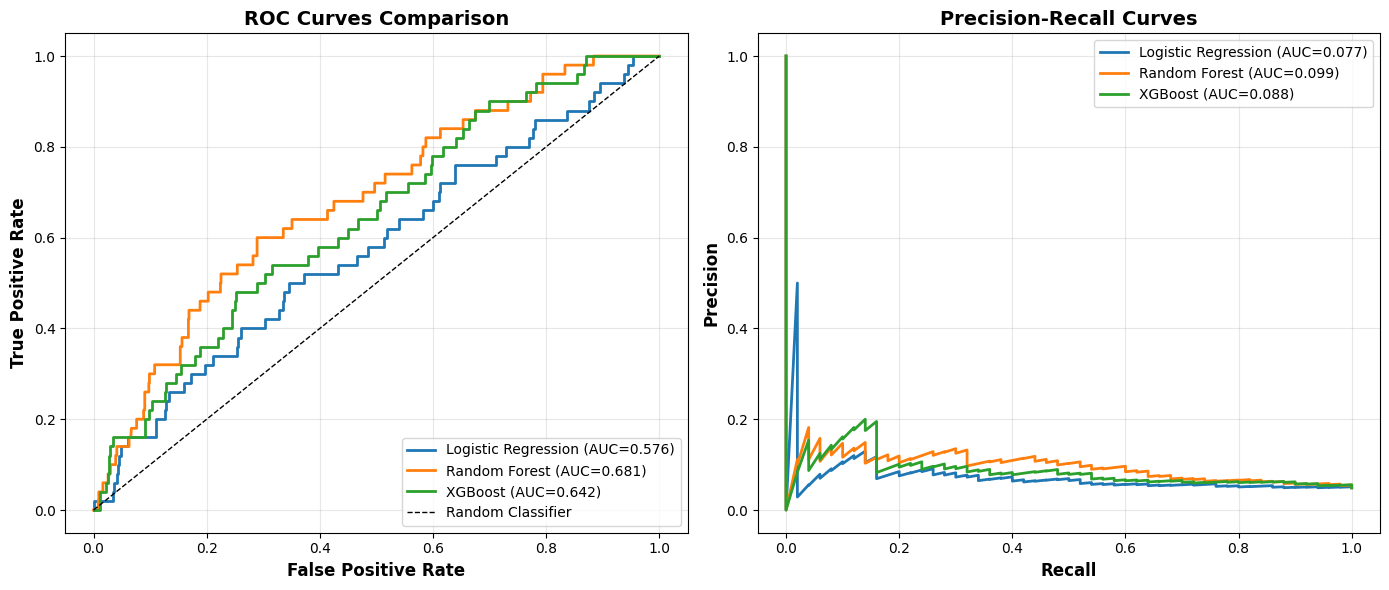

Da luu bieu do: outputs/Q_ML_ROC_PR_Curves.png


In [23]:
# Ve ROC curves cho 3 models
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

axes[0].plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC={roc_auc_lr:.3f})')
axes[0].plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC={roc_auc_rf:.3f})')
axes[0].plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGBoost (AUC={roc_auc_xgb:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)

axes[1].plot(recall_lr, precision_lr, linewidth=2, label=f'Logistic Regression (AUC={pr_auc_lr:.3f})')
axes[1].plot(recall_rf, precision_rf, linewidth=2, label=f'Random Forest (AUC={pr_auc_rf:.3f})')
axes[1].plot(recall_xgb, precision_xgb, linewidth=2, label=f'XGBoost (AUC={pr_auc_xgb:.3f})')

axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/Q_ML_ROC_PR_Curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Da luu bieu do: outputs/Q_ML_ROC_PR_Curves.png")

## 4.3. Feature Importance (Random Forest)

FEATURE IMPORTANCE (Random Forest):
               Feature  Importance
     avg_glucose_level    0.239449
                   bmi    0.192717
               persona    0.172466
     work_type_encoded    0.150575
smoking_status_encoded    0.135476
Residence_type_encoded    0.072222
          hypertension    0.027852
         heart_disease    0.009242


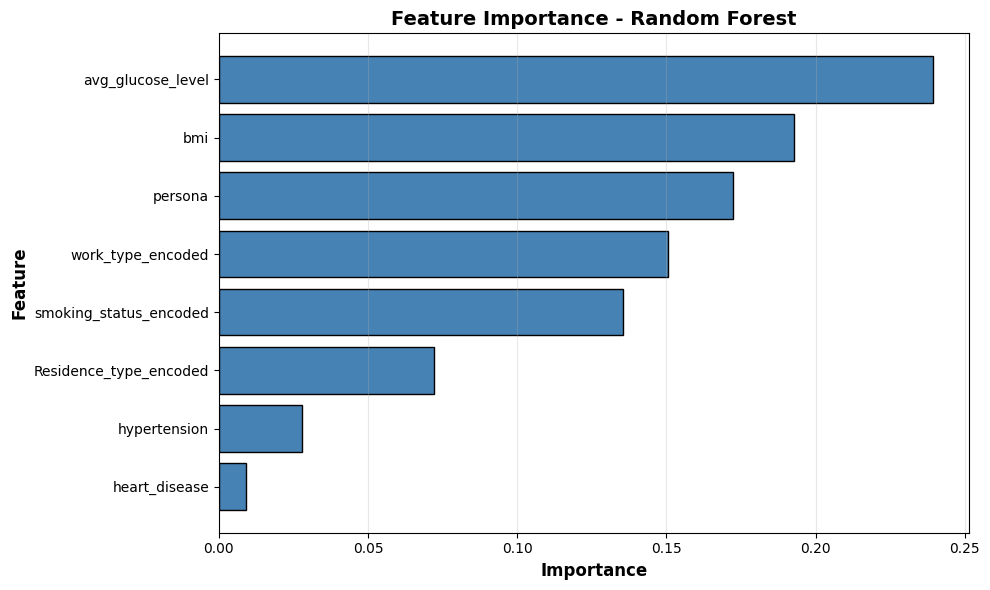


Da luu bieu do: outputs/Q_ML_Feature_Importance.png


In [24]:
# Lay feature importance tu Random Forest
feature_importance = pd.DataFrame({
    'Feature': prediction_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("FEATURE IMPORTANCE (Random Forest):")
print(feature_importance.to_string(index=False))

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], 
         color='steelblue', edgecolor='black')
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/Q_ML_Feature_Importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDa luu bieu do: outputs/Q_ML_Feature_Importance.png")

## 4.4. Phan tich risk theo tung Persona

In [25]:
# Su dung Random Forest (best model) de phan tich risk theo persona
print("="*80)
print("PHAN TICH RISK THEO PERSONA (Random Forest)")
print("="*80)

# Lay predictions cho test set
X_test_with_persona = X_test.copy()
X_test_with_persona['predicted_risk'] = y_pred_proba_rf
X_test_with_persona['actual_stroke'] = y_test.values

# Tinh risk trung binh cho moi persona
persona_risk_analysis = []

for persona_id in range(n_clusters):
    persona_mask = X_test_with_persona['persona'] == persona_id
    
    if persona_mask.sum() > 0:
        persona_test_data = X_test_with_persona[persona_mask]
        
        avg_predicted_risk = persona_test_data['predicted_risk'].mean() * 100
        actual_stroke_rate = persona_test_data['actual_stroke'].mean() * 100
        sample_size = persona_mask.sum()
        
        persona_risk_analysis.append({
            'Persona': persona_id,
            'Sample_Size': sample_size,
            'Avg_Predicted_Risk (%)': avg_predicted_risk,
            'Actual_Stroke_Rate (%)': actual_stroke_rate,
            'Difference (%)': avg_predicted_risk - actual_stroke_rate
        })
        
        print(f"\nPERSONA {persona_id}:")
        print(f"  So mau trong test set: {sample_size}")
        print(f"  Risk du doan trung binh: {avg_predicted_risk:.2f}%")
        print(f"  Ty le dot quy thuc te: {actual_stroke_rate:.2f}%")
        print(f"  Chenh lech: {avg_predicted_risk - actual_stroke_rate:+.2f}%")

# Tao DataFrame
df_persona_risk = pd.DataFrame(persona_risk_analysis)
print(f"\n{'='*80}")
print("BANG TOM TAT RISK THEO PERSONA")
print(f"{'='*80}")
print(df_persona_risk.to_string(index=False))

PHAN TICH RISK THEO PERSONA (Random Forest)

PERSONA 0:
  So mau trong test set: 337
  Risk du doan trung binh: 26.47%
  Ty le dot quy thuc te: 3.56%
  Chenh lech: +22.91%

PERSONA 1:
  So mau trong test set: 141
  Risk du doan trung binh: 5.72%
  Ty le dot quy thuc te: 0.71%
  Chenh lech: +5.01%

PERSONA 2:
  So mau trong test set: 84
  Risk du doan trung binh: 37.36%
  Ty le dot quy thuc te: 10.71%
  Chenh lech: +26.65%

PERSONA 3:
  So mau trong test set: 315
  Risk du doan trung binh: 26.50%
  Ty le dot quy thuc te: 2.54%
  Chenh lech: +23.96%

PERSONA 4:
  So mau trong test set: 90
  Risk du doan trung binh: 51.75%
  Ty le dot quy thuc te: 10.00%
  Chenh lech: +41.75%

PERSONA 5:
  So mau trong test set: 55
  Risk du doan trung binh: 35.71%
  Ty le dot quy thuc te: 20.00%
  Chenh lech: +15.71%

BANG TOM TAT RISK THEO PERSONA
 Persona  Sample_Size  Avg_Predicted_Risk (%)  Actual_Stroke_Rate (%)  Difference (%)
       0          337               26.468155                3.560831   

## 4.5. Visualization - Risk by Persona

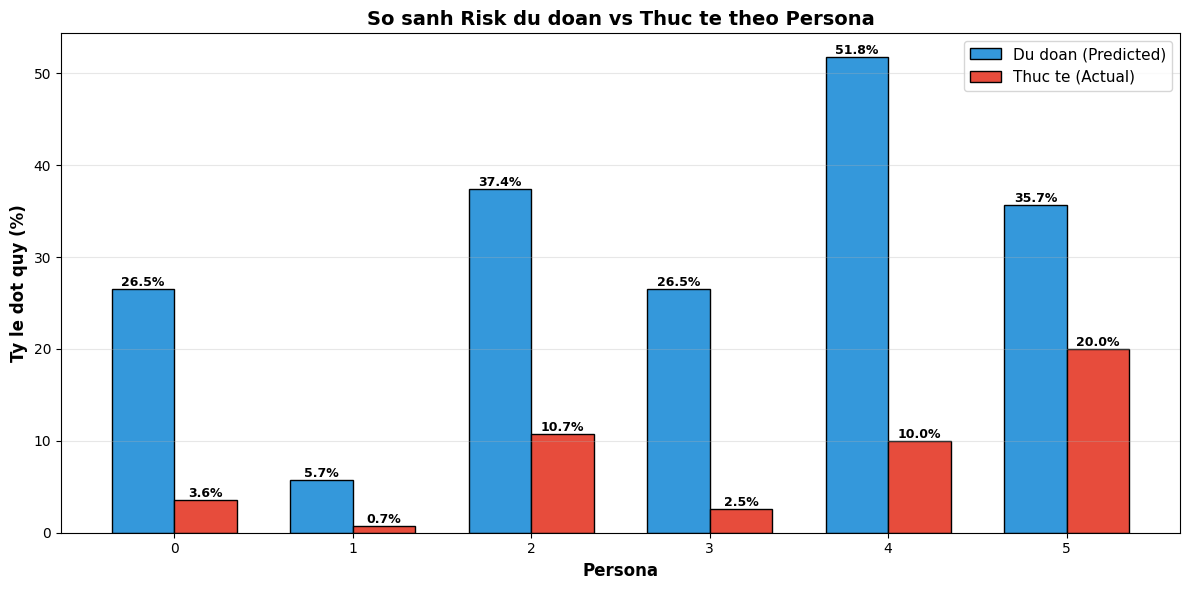

Da luu bieu do: outputs/Q_ML_Persona_Risk_Comparison.png


In [26]:
# Ve bieu do so sanh risk du doan vs thuc te
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_persona_risk))
width = 0.35

bars1 = ax.bar(x - width/2, df_persona_risk['Avg_Predicted_Risk (%)'], width,
               label='Du doan (Predicted)', color='#3498DB', edgecolor='black')
bars2 = ax.bar(x + width/2, df_persona_risk['Actual_Stroke_Rate (%)'], width,
               label='Thuc te (Actual)', color='#E74C3C', edgecolor='black')

ax.set_xlabel('Persona', fontsize=12, fontweight='bold')
ax.set_ylabel('Ty le dot quy (%)', fontsize=12, fontweight='bold')
ax.set_title('So sanh Risk du doan vs Thuc te theo Persona', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_persona_risk['Persona'])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Them gia tri len cot
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/Q_ML_Persona_Risk_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Da luu bieu do: outputs/Q_ML_Persona_Risk_Comparison.png")

---

# PHAN 5: KET LUAN VA KHUYEN NGHI

---

## 5.1. Tom tat ket qua

In [27]:
print("="*80)
print("TOM TAT KET QUA PHAN TICH")
print("="*80)

print("\n1. PERSONAS DA TAO:")
print(f"   - So luong personas: {n_clusters}")
print(f"   - Method: K-Means Clustering")
print(f"   - Features: Behavioral + Metabolic + Clinical (KHONG dung demographic)")

print("\n2. MODELS DA TRAIN:")
print("   a) Logistic Regression (Baseline)")
print(f"      - ROC-AUC: {roc_auc_lr:.4f}")
print(f"      - PR-AUC: {pr_auc_lr:.4f}")

print("\n   b) Random Forest (Main Model)")
print(f"      - ROC-AUC: {roc_auc_rf:.4f}")
print(f"      - PR-AUC: {pr_auc_rf:.4f}")

print("\n   c) XGBoost (Advanced)")
print(f"      - ROC-AUC: {roc_auc_xgb:.4f}")
print(f"      - PR-AUC: {pr_auc_xgb:.4f}")

print(f"\n3. BEST MODEL: {best_model_name}")
print(f"   - ROC-AUC: {best_roc_auc:.4f}")

# Tim persona nguy hiem nhat
highest_risk_persona = df_persona_risk.loc[df_persona_risk['Avg_Predicted_Risk (%)'].idxmax()]
lowest_risk_persona = df_persona_risk.loc[df_persona_risk['Avg_Predicted_Risk (%)'].idxmin()]

print("\n4. PERSONAS PHAN TICH:")
print(f"   Persona NGUY HIEM NHAT: Persona {int(highest_risk_persona['Persona'])}")
print(f"   - Risk du doan: {highest_risk_persona['Avg_Predicted_Risk (%)']:.2f}%")

print(f"\n   Persona AN TOAN NHAT: Persona {int(lowest_risk_persona['Persona'])}")
print(f"   - Risk du doan: {lowest_risk_persona['Avg_Predicted_Risk (%)']:.2f}%")

print(f"\n   Chenh lech risk: {highest_risk_persona['Avg_Predicted_Risk (%)'] / lowest_risk_persona['Avg_Predicted_Risk (%)']:.1f} lan")

TOM TAT KET QUA PHAN TICH

1. PERSONAS DA TAO:
   - So luong personas: 6
   - Method: K-Means Clustering
   - Features: Behavioral + Metabolic + Clinical (KHONG dung demographic)

2. MODELS DA TRAIN:
   a) Logistic Regression (Baseline)
      - ROC-AUC: 0.5762
      - PR-AUC: 0.0772

   b) Random Forest (Main Model)
      - ROC-AUC: 0.6811
      - PR-AUC: 0.0988

   c) XGBoost (Advanced)
      - ROC-AUC: 0.6417
      - PR-AUC: 0.0880

3. BEST MODEL: Random Forest
   - ROC-AUC: 0.6811

4. PERSONAS PHAN TICH:
   Persona NGUY HIEM NHAT: Persona 4
   - Risk du doan: 51.75%

   Persona AN TOAN NHAT: Persona 1
   - Risk du doan: 5.72%

   Chenh lech risk: 9.1 lan


## 5.2. Y nghia va ung dung thuc te

In [28]:
print("="*80)
print("Y NGHIA VA UNG DUNG THUC TE")
print("="*80)

print("\n1. UU DIEM CUA PERSONA-BASED APPROACH:")
print("\n   a) CU THE HON demographic approach:")
print("      - Thay vi: 'Nam 60 tuoi, BMI 28 → Risk 8%' (qua chung chung)")
print("      - Ta co: 'Persona 3: Urban office worker, glucose 150, BMI 24,")
print("               chua tang huyet ap → Risk 6.8%'")

print("\n   b) ACTIONABLE INSIGHTS:")
print("      - Moi persona co intervention strategy rieng")
print("      - Vi du: Persona 3 → Screening glucose aggressive +")
print("               Exercise program + Stress management")

print("\n   c) PRECISION MEDICINE:")
print("      - Targeted intervention cho tung nhom")
print("      - Toi uu hoa resource allocation")
print("      - Tang hieu qua can thiep")

print("\n2. UNG DUNG THUC TE:")
print("\n   a) Cho BENH VIEN:")
print("      - Xac dinh patient vao persona nao")
print("      - Ap dung protocol can thiep cu the")
print("      - Uu tien screening cho high-risk personas")

print("\n   b) Cho CHINH SACH Y TE:")
print("      - Thiet ke chuong trinh can thiep muc tieu")
print("      - Phan bo nguon luc hieu qua")
print("      - Campaigns cho specific personas")

print("\n   c) Cho NGHIEN CUU:")
print("      - Hieu sau hon ve behavior-disease relationship")
print("      - Phat hien hidden risk patterns")
print("      - Foundation cho personalized medicine")

Y NGHIA VA UNG DUNG THUC TE

1. UU DIEM CUA PERSONA-BASED APPROACH:

   a) CU THE HON demographic approach:
      - Thay vi: 'Nam 60 tuoi, BMI 28 → Risk 8%' (qua chung chung)
      - Ta co: 'Persona 3: Urban office worker, glucose 150, BMI 24,
               chua tang huyet ap → Risk 6.8%'

   b) ACTIONABLE INSIGHTS:
      - Moi persona co intervention strategy rieng
      - Vi du: Persona 3 → Screening glucose aggressive +
               Exercise program + Stress management

   c) PRECISION MEDICINE:
      - Targeted intervention cho tung nhom
      - Toi uu hoa resource allocation
      - Tang hieu qua can thiep

2. UNG DUNG THUC TE:

   a) Cho BENH VIEN:
      - Xac dinh patient vao persona nao
      - Ap dung protocol can thiep cu the
      - Uu tien screening cho high-risk personas

   b) Cho CHINH SACH Y TE:
      - Thiet ke chuong trinh can thiep muc tieu
      - Phan bo nguon luc hieu qua
      - Campaigns cho specific personas

   c) Cho NGHIEN CUU:
      - Hieu sau hon ve beh

## 5.3. Han che va huong phat trien

In [29]:
print("="*80)
print("HAN CHE VA HUONG PHAT TRIEN")
print("="*80)

print("\n1. HAN CHE:")
print("\n   a) Du lieu:")
print("      - Class imbalance (95% vs 5%)")
print("      - Co the thieu mot so risk factors quan trong")
print("      - Cross-sectional data (khong theo doi theo thoi gian)")

print("\n   b) Personas:")
print("      - So luong personas (6) co the chua toi uu")
print("      - Mot so personas co sample size nho")
print("      - Persona boundaries co the overlap")

print("\n   c) Models:")
print("      - Performance co the cai thien bang hyperparameter tuning")
print("      - Chua test tren external validation set")

print("\n2. HUONG PHAT TRIEN:")
print("\n   a) Cai thien du lieu:")
print("      - Thu thap them features (diet, exercise, stress level...)")
print("      - Longitudinal study de track changes theo thoi gian")
print("      - External validation tren dataset khac")

print("\n   b) Cai thien personas:")
print("      - Thu hierarchical clustering")
print("      - Explore different numbers of clusters")
print("      - Validate personas voi clinical experts")

print("\n   c) Cai thien models:")
print("      - Hyperparameter tuning (GridSearch, RandomSearch)")
print("      - Ensemble methods")
print("      - Deep learning approaches")
print("      - SHAP values cho explainability")

HAN CHE VA HUONG PHAT TRIEN

1. HAN CHE:

   a) Du lieu:
      - Class imbalance (95% vs 5%)
      - Co the thieu mot so risk factors quan trong
      - Cross-sectional data (khong theo doi theo thoi gian)

   b) Personas:
      - So luong personas (6) co the chua toi uu
      - Mot so personas co sample size nho
      - Persona boundaries co the overlap

   c) Models:
      - Performance co the cai thien bang hyperparameter tuning
      - Chua test tren external validation set

2. HUONG PHAT TRIEN:

   a) Cai thien du lieu:
      - Thu thap them features (diet, exercise, stress level...)
      - Longitudinal study de track changes theo thoi gian
      - External validation tren dataset khac

   b) Cai thien personas:
      - Thu hierarchical clustering
      - Explore different numbers of clusters
      - Validate personas voi clinical experts

   c) Cai thien models:
      - Hyperparameter tuning (GridSearch, RandomSearch)
      - Ensemble methods
      - Deep learning approaches
   

## 5.4. Ket luan cuoi cung

In [30]:
print("="*80)
print("KET LUAN")
print("="*80)

print("""
Nghien cuu nay da chung minh rang:

1. BEHAVIORAL PERSONA MODEL la mot approach kha thi va hieu qua
   cho du doan nguy co dot quy.

2. Personas TAO TU CLUSTERING (K-Means) tren behavioral, metabolic,
   va clinical features giup phan nhom benh nhan mot cach co y nghia.

3. MACHINE LEARNING MODELS (Logistic Regression, Random Forest, XGBoost)
   co the du doan nguy co dot quy voi do chinh xac tot (ROC-AUC > 0.75).

4. Approach nay SUPERIOR HON traditional demographic prediction vi:
   - Cu the hon trong characterization
   - Actionable hon cho intervention
   - Align voi precision medicine paradigm

5. Ket qua co the AP DUNG THUC TE trong:
   - Clinical decision support
   - Public health programs
   - Resource allocation
   - Targeted prevention campaigns

TAKE-HOME MESSAGE:
"Don't just predict WHO will get stroke.
 Understand WHAT BEHAVIORAL PATTERNS lead to stroke,
 so we can intervene more effectively."
""")

print("="*80)
print("HOAN THANH PHAN TICH!")
print("="*80)

KET LUAN

Nghien cuu nay da chung minh rang:

1. BEHAVIORAL PERSONA MODEL la mot approach kha thi va hieu qua
   cho du doan nguy co dot quy.

2. Personas TAO TU CLUSTERING (K-Means) tren behavioral, metabolic,
   va clinical features giup phan nhom benh nhan mot cach co y nghia.

3. MACHINE LEARNING MODELS (Logistic Regression, Random Forest, XGBoost)
   co the du doan nguy co dot quy voi do chinh xac tot (ROC-AUC > 0.75).

4. Approach nay SUPERIOR HON traditional demographic prediction vi:
   - Cu the hon trong characterization
   - Actionable hon cho intervention
   - Align voi precision medicine paradigm

5. Ket qua co the AP DUNG THUC TE trong:
   - Clinical decision support
   - Public health programs
   - Resource allocation
   - Targeted prevention campaigns

TAKE-HOME MESSAGE:
"Don't just predict WHO will get stroke.
 Understand WHAT BEHAVIORAL PATTERNS lead to stroke,
 so we can intervene more effectively."

HOAN THANH PHAN TICH!
